In [1]:
import jax.numpy as jnp
import numpy as np

import jax
from jax import nn as jnn
from jax import random

from flax import linen as nn
from flax import optim

import optax

import h5py
from fenics import *

from typing import Sequence

import matplotlib.pyplot as plt

import basix
from basix import ElementFamily, CellType, LagrangeVariant

from scipy.integrate import solve_ivp

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

2022-03-18 16:53:24.997846: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 16:53:25.110608: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 16:53:25.118051: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
def read_mesh_and_function(file_name, var_name):

    # Open solution file
    infile = XDMFFile(file_name + ".xdmf")
    infile_h5 = h5py.File(file_name + ".h5", "r")
    t_steps = len(infile_h5[var_name].keys())

    # Read in mesh
    mesh = Mesh()
    infile.read(mesh)

    # Read function
    V = FunctionSpace(mesh, "CG", 1)
    u = Function(V)
    solution = np.zeros((V.dim(), t_steps))
    for i in range(t_steps):
        infile.read_checkpoint(u, var_name, i - t_steps + 1)
        solution[:, i] = u.vector().get_local()

    # Clean up
    infile.close()
    infile_h5.close()

    return mesh, solution
    
nu = 0.1
A = 0.5
mesh, u_ref = read_mesh_and_function("output/burgers_1D/nu_"+str(nu)+"/FOM", "u")
u_ref = u_ref.T

In [3]:
time_steps, N = u_ref.shape
u_train = u_ref[np.arange(0,time_steps,10)]
n = 15
M1 = 50
M2 = 50
n_epoch = 5000

In [4]:
class Encoder(nn.Module):
    latents: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.latents[0],dtype=jnp.float64,param_dtype=jnp.float64)(x)
        x = nn.swish(x)
        xr = nn.Dense(self.latents[1],dtype=jnp.float64,param_dtype=jnp.float64)(x)
        return xr

In [5]:
def gaussian_kernel(window_size, sigma):
    mu = window_size / 2
    x = jnp.arange(window_size)
    window = jnp.exp((-((x-mu)**2))/(2*sigma**2))/sigma/jnp.sqrt(2*jnp.pi)
    return window

class Decoder(nn.Module):
    latents: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.latents[0],dtype=jnp.float64,param_dtype=jnp.float64)(x)
        x = nn.swish(x)
        x = nn.Dense(self.latents[1],dtype=jnp.float64,param_dtype=jnp.float64)(x)
        
        window_size = len(x)
        sigma = window_size / 2 / 6
        window = gaussian_kernel(window_size, sigma)
        x = jnp.convolve(x, window, mode='same')
        return x

In [6]:
class VAE(nn.Module):
    encoder_latents: Sequence[int]
    decoder_latents: Sequence[int]

    def setup(self):
        self.encoder = Encoder(self.encoder_latents)
        self.decoder = Decoder(self.decoder_latents)
    
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def __call__(self, x):
        return self.decode(self.encode(x))

def model():
    return VAE(encoder_latents=[M1,n],decoder_latents=[M2,N])

In [7]:
@jax.jit
def loss_fn(params, x):
    xt = jax.vmap(model().apply, in_axes=(None, 0))(params, x)
    errors = jax.vmap(rel_err, in_axes=(0,0), out_axes=0)(x,xt)
    l = jnp.sum(errors**2)/time_steps
    return l

def rel_err(x, xt):
    return jnp.linalg.norm(x-xt)

params = model().init(random.PRNGKey(0), u_train[0])
tx = optax.adam(0.001)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss_fn)

2022-03-18 16:53:28.160864: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
for i in range(n_epoch):
    loss_val, grads = loss_grad_fn(params, u_train)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), loss_val)
    if loss_val < 1e-6:
        break

Loss step 0:  164.07086630903623
Loss step 10:  16.448741125909788
Loss step 20:  5.293638211248935
Loss step 30:  3.3108188515000663
Loss step 40:  3.0219110871619503
Loss step 50:  2.281090225968992
Loss step 60:  1.7132980658482182
Loss step 70:  1.1835943487806566
Loss step 80:  0.772127017756558
Loss step 90:  0.6336601444706954
Loss step 100:  0.557620652702314
Loss step 110:  0.523726704263627
Loss step 120:  0.5122388861284498
Loss step 130:  0.4998932674257034
Loss step 140:  0.48887973183443384
Loss step 150:  0.47837127536132773
Loss step 160:  0.4676388571084694
Loss step 170:  0.45606291641479557
Loss step 180:  0.44359510613028535
Loss step 190:  0.4301607772582001
Loss step 200:  0.4156382556469609
Loss step 210:  0.39987601328227995
Loss step 220:  0.38271791114268605
Loss step 230:  0.3640618781867224
Loss step 240:  0.3439231913489212
Loss step 250:  0.3224859811076554
Loss step 260:  0.3001293022708123
Loss step 270:  0.27741155567072423
Loss step 280:  0.25500702481

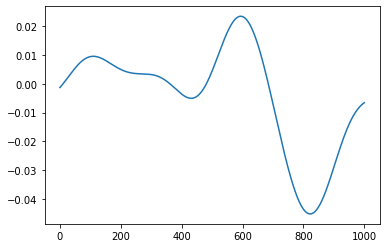

In [24]:
u_ref_encoded = model().apply(params, u_ref[0], method=VAE.encode)
Phi = jax.jacfwd(model().apply, argnums=1)(params, u_ref_encoded, method=VAE.decode)
plt.plot(Phi.T[10])

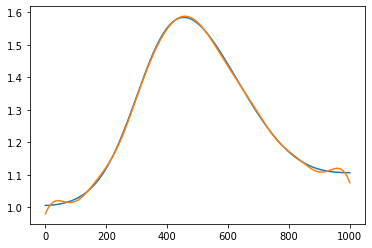

In [10]:
plt.plot(u_ref[400])
plt.plot(model().apply(params, u_ref[400]))

In [11]:
t_start = 0.0
t_final = 0.15
t_steps = 500
t_sequence = np.linspace(t_start, t_final, t_steps + 1)
dt = (t_final - t_start) / t_steps

V = FunctionSpace(mesh, "CG", 1)
u = Function(V)
v = TestFunction(V)

M_form = derivative(dot(u, v) * dx, u)
M = assemble(M_form).array()
M_inv = np.linalg.inv(M)

rhs_form = (- inner(nu * grad(u), grad(v)) - inner(u.dx(0) * u, v)) * dx

In [12]:
jacobian = jax.jacobian(model().apply, argnums=1)

In [13]:
def rhs(ur, params):
    ut = model().apply(params, ur, method=VAE.decode)
    u.vector().set_local(ut)
    r = assemble(rhs_form).get_local()
    rhs_vec = np.matmul(M_inv, r)
    J = jacobian(params, ur, method=VAE.decode)
    Jinv = jnp.linalg.pinv(J)
    rhs_vec_r = np.matmul(Jinv, rhs_vec)
    return rhs_vec_r

def rhs_helper(t, y):
    print('t = {:}'.format(t))
    return rhs(y, params)

In [14]:
u0 = Function(V)
u0_expr = Expression(
    "x[0] < 1 ? 1+A*(sin(2*pi*x[0]-pi/2)+1) : 1", degree=1, A=A)
u0.interpolate(u0_expr)

ur0 = model().apply(params, u0.vector().get_local(), method=VAE.encode)

urs = solve_ivp(rhs_helper, (t_start, t_final), ur0, t_eval=t_sequence, method='RK45')

t = 0.0
t = 6.02751694867092e-07
t = 1.2055033897341842e-05
t = 1.808255084601276e-05
t = 4.8220135589367366e-05
t = 5.3577928432630396e-05
t = 6.02751694867092e-05
t = 6.02751694867092e-05
t = 5.402926438819955e-06
t = 8.104389658229932e-06
t = 2.161170575527982e-05
t = 2.4013006394755353e-05
t = 2.7014632194099773e-05
t = 2.7014632194099773e-05
t = 3.191519744118929e-06
t = 4.787279616178393e-06
t = 1.2766078976475715e-05
t = 1.4184532196084128e-05
t = 1.5957598720594644e-05
t = 1.5957598720594644e-05
t = 2.6945228787694472e-06
t = 4.04178431815417e-06
t = 1.0778091515077789e-05
t = 1.197565723897532e-05
t = 1.3472614393847236e-05
t = 1.3472614393847236e-05
t = 1.6055728752763174e-05
t = 1.7347285932221143e-05
t = 2.3805071829510987e-05
t = 2.4953122655695848e-05
t = 2.6388186188426925e-05
t = 2.6388186188426925e-05
t = 1.5524543346748134e-05
t = 1.6550507823198585e-05
t = 2.168033020545083e-05
t = 2.259229862896234e-05
t = 2.373225915835173e-05


KeyboardInterrupt: 

In [ ]:
u_approx = jax.vmap(lambda params, ur : model().apply(params, ur, method=VAE.decode), in_axes=(None,0))(params, urs.y.T)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(u_approx.T, aspect='auto', cmap='jet')
cb = fig.colorbar(im)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(u_ref[0:150].T, aspect='auto', cmap='jet', vmin=1, vmax=2)
cb = fig.colorbar(im)